In [12]:
from numpy import *
from LabFuncs import *
from Params import *
from HaloFuncs import *
from WIMPFuncs import *

dat = loadtxt('../data/gvmin/gvmin_SHMpp.txt')
v_min = dat[0,:]
gmin0 = dat[1:,:]
gmin0_gf = loadtxt('../data/gvmin/gvmin_SHMpp_GF.txt',skiprows=1)
gmin_sub = loadtxt('../data/gvmin/gvmin_Shards.txt',skiprows=1)
gmin_sub_gf = loadtxt('../data/gvmin/gvmin_Shards_GF.txt',skiprows=1)

ndays = shape(gmin0)[0]
days = linspace(0,365,ndays)





# Ionization energy range
n = 2000
E_ee = logspace(log(0.01),log10(50.0),n)

# DAMA Config.
MT = 2.46
Avals = array([23,127])
Qvals = array([0.3,0.09])
def DAMAEnergyRes(Q,E_nr):
    alph = 0.448
    beta = 9.1e-3
    return alph*sqrt(Q*E_nr)+beta*Q*E_nr

Emask1 = (E_ee>1.0)*(E_ee<3.0)
Emask2 = (E_ee>1.0)*(E_ee<6.0)

# DM params
m_chi = 50.0
sigma_p = 1.0e-45
pltname = 'Shards_annualmod_gravfocus'


# diff rates
dR0_NaI = zeros(shape=(ndays,n,2))
dR_NaI = zeros(shape=(ndays,n,2))
dR0_gf_NaI = zeros(shape=(ndays,n,2))
dR_gf_NaI = zeros(shape=(ndays,n,2))

# total rates
R_NaI = zeros(shape=(ndays,2,2))
R0_NaI = zeros(shape=(ndays,2,2))
R_gf_NaI = zeros(shape=(ndays,2,2))
R0_gf_NaI = zeros(shape=(ndays,2,2))


for nuc in range(0,2):
    A = Avals[nuc]
    Q = Qvals[nuc]
    E_nr = E_ee/Q
    v_min_E = MinimumWIMPSpeed(E_nr,A,m_chi)
    sig_E = DAMAEnergyRes(Q,E_nr)
    for i in range(0,ndays):
        g0 = interp(v_min_E,v_min,gmin0[i,:])
        gs = interp(v_min_E,v_min,gmin_sub[i,:])
        g0_gf = interp(v_min_E,v_min,gmin0_gf[i,:])
        gs_gf = interp(v_min_E,v_min,gmin_sub_gf[i,:])
        dR_NaI[i,:,nuc] = SmearE(E_nr,diffRecoilRate_SI(E_nr,gs,A,sigma_p,m_chi,rho_0=0.55),sig_E)
        dR_gf_NaI[i,:,nuc] = SmearE(E_nr,diffRecoilRate_SI(E_nr,gs_gf,A,sigma_p,m_chi,rho_0=0.55),sig_E)
        dR0_NaI[i,:,nuc] = SmearE(E_nr,diffRecoilRate_SI(E_nr,g0,A,sigma_p,m_chi,rho_0=0.55),sig_E)
        dR0_gf_NaI[i,:,nuc] = SmearE(E_nr,diffRecoilRate_SI(E_nr,g0_gf,A,sigma_p,m_chi,rho_0=0.55),sig_E)        
        
        
        R_NaI[i,nuc,0] = MT*trapz(dR_NaI[i,Emask1,nuc],E_ee[Emask1])
        R_gf_NaI[i,nuc,0] = MT*trapz(dR_gf_NaI[i,Emask1,nuc],E_ee[Emask1])

        R0_NaI[i,nuc,0] = MT*trapz(dR0_NaI[i,Emask1,nuc],E_ee[Emask1])
        R0_gf_NaI[i,nuc,0] = MT*trapz(dR0_gf_NaI[i,Emask1,nuc],E_ee[Emask1])
        
        R_NaI[i,nuc,1] = MT*trapz(dR_NaI[i,Emask2,nuc],E_ee[Emask2])
        R_gf_NaI[i,nuc,1] = MT*trapz(dR_gf_NaI[i,Emask2,nuc],E_ee[Emask2])

        R0_NaI[i,nuc,1] = MT*trapz(dR0_NaI[i,Emask2,nuc],E_ee[Emask2])
        R0_gf_NaI[i,nuc,1] = MT*trapz(dR0_gf_NaI[i,Emask2,nuc],E_ee[Emask2])

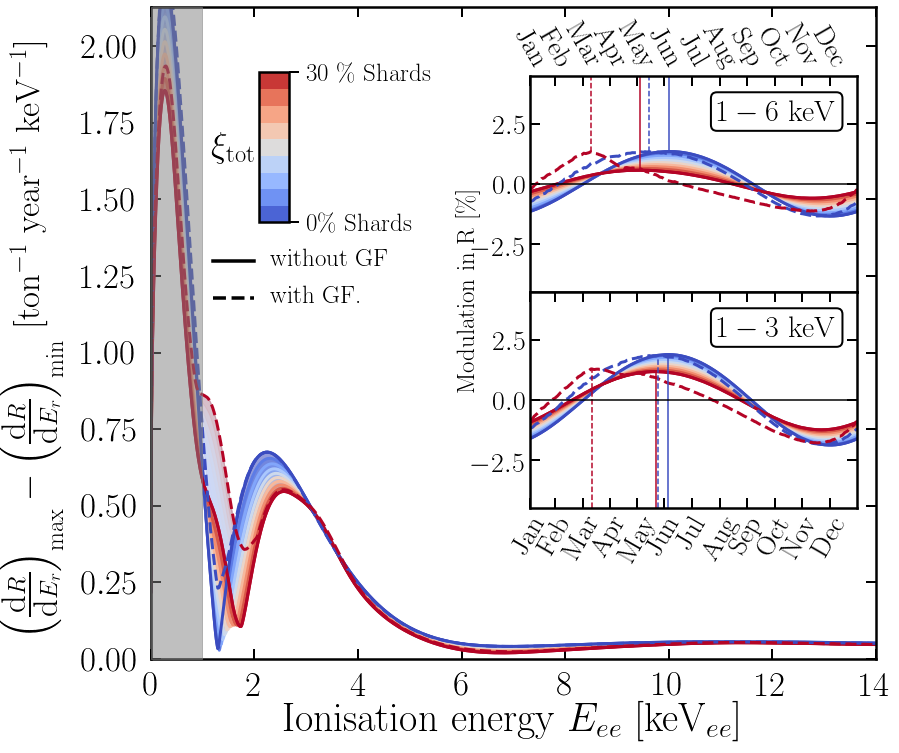

In [16]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib.cm as cm


# Set plot rc params
plt.rcParams['axes.linewidth'] = 2.5
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

dR = sum(dR_NaI,2)
dR_gf = sum(dR_gf_NaI,2)
dR0 = sum(dR0_NaI,2)
dR0_gf = sum(dR0_gf_NaI,2)

def ModulationAmplitude(dRv):
    t0 = 152
    t1 = mod(int(t0+ndays/2),364)
    ni = shape(dRv)[1]
    Rdiffv = zeros(shape=ni)
    for i in range(0,n):
        Rdiffv[i] = max(dRv[:,i])-min(dRv[:,i])
    return Rdiffv


# Figure
fig = plt.figure(figsize=(13,12))
ax1 = fig.add_subplot(111)
left, bottom, width, height = [0.53, 0.55, 0.35, 0.25]
ax2 = fig.add_axes([left, bottom, width, height])
left, bottom, width, height = [0.53, 0.3, 0.35, 0.25]
ax3 = fig.add_axes([left, bottom, width, height])

n_xi = 10
xi_vals = linspace(0,0.35,n_xi)
col = (cm.coolwarm(linspace(0,1,n_xi)))
cmap = cm.coolwarm

# Main plot
plt.sca(ax1)
y2 = ModulationAmplitude(xi_vals[-1]*dR+(1-xi_vals[-1])*dR0)
y2_gf = ModulationAmplitude(xi_vals[-1]*dR_gf+(1-xi_vals[-1])*dR0_gf)
for i in range(0,n_xi):
    y = ModulationAmplitude(xi_vals[i]*dR+(1-xi_vals[i])*dR0)
    plt.fill_between(E_ee,y,y2=y2,color=col[i,:],alpha=0.5)
    plt.plot(E_ee,y,'-',color=col[i,:],linewidth=3)
    
plt.plot(E_ee,ModulationAmplitude(dR0),linewidth=3,color=col[0,:])
plt.plot(E_ee,y2,linewidth=3,color=col[-1,:])


for i in range(0,n_xi):
    y = ModulationAmplitude(xi_vals[i]*dR_gf+(1-xi_vals[i])*dR0_gf)
    plt.fill_between(E_ee,y,y2=y2_gf,color=col[i,:],alpha=0.1)
plt.plot(E_ee,ModulationAmplitude(dR0_gf),'--',linewidth=3,color=col[0,:])
plt.plot(E_ee,y2_gf,'--',linewidth=3,color=col[-1,:])
ymax = amax(y2_gf)*1.1

plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xlabel(r"Ionisation energy $E_{ee}$ [keV$_{ee}$]",fontsize=40);
plt.ylabel(r"$\left(\frac{\textrm{d}R}{\textrm{d}E_r}\right)_{\rm max} - \left(\frac{\textrm{d}R}{\textrm{d}E_r}\right)_{\rm min}$ [ton$^{-1}$ year$^{-1}$ keV$^{-1}$]" ,fontsize=35,labelpad=10);
plt.fill_between([0,1],[ymax,ymax],y2=0.0,alpha=0.5,color='gray',edgecolor='none',zorder=5)
ax1.set_xlim(left=0.0,right=14.0)
ax1.set_ylim(bottom=0.0,top=ymax)
ax1.tick_params(which='major',direction='in',width=2,length=10,right=True,top=True,pad=12)
ax1.tick_params(which='minor',direction='in',width=1,length=7,right=True,top=True)
#ax1.set_xscale('log')

# second "legend"
ax1.plot([1.2,2.0],[1.3,1.3], 'k-',linewidth=3.5)
ax1.plot([1.2,2.0],[1.18,1.18], 'k--',linewidth=3.5)
ax1.text(2.3,1.32-0.04,'without GF',fontsize=25)
ax1.text(2.3,1.2-0.04,'with GF.',fontsize=25)





# Inset plot 1
plt.sca(ax2)
ymax = 4.5

R = sum(R_NaI[:,:,0],1)
R_gf = sum(R_gf_NaI[:,:,0],1)
R0 = sum(R0_NaI[:,:,0],1)
R0_gf = sum(R0_gf_NaI[:,:,0],1)

R0mid = (max(R0)+min(R0))/2.0
Rmid = (max(R)+min(R))/2.0
R0mid_gf = (max(R0_gf)+min(R0_gf))/2.0
Rmid_gf = (max(R_gf)+min(R_gf))/2.0
y2 = 100*xi_vals[-1]*(R-Rmid)/Rmid+100*(1.0-xi_vals[-1])*(R0-R0mid)/R0mid
y2_gf = 100*xi_vals[-1]*(R_gf-Rmid_gf)/Rmid_gf+100*(1.0-xi_vals[-1])*(R0_gf-R0mid_gf)/R0mid_gf

for i in range(0,n_xi):
    Rt = 100*xi_vals[i]*(R-Rmid)/Rmid+100*(1.0-xi_vals[i])*(R0-R0mid)/R0mid
    plt.fill_between(days,Rt,y2=y2,color=col[i,:],alpha=0.5)
    plt.plot(days,Rt,'-',color=col[i,:],linewidth=3)
plt.plot(days,100*(R0-R0mid)/R0mid,linewidth=3,color=col[0,:])
plt.plot(days,y2,linewidth=3,color=col[-1,:])
plt.plot(days,100*(R0_gf-R0mid_gf)/R0mid_gf,'--',linewidth=3,color=col[0,:])
plt.plot(days,y2_gf,'--',linewidth=3,color=col[-1,:])

# vertical lines
diffR = 100*(R0-R0mid)/R0mid
plt.plot([days[argmax(diffR)],days[argmax(diffR)]],[amax(diffR),ymax],'-',color=col[0,:])
plt.plot([days[argmax(y2)],days[argmax(y2)]],[amax(y2),ymax],'-',color=col[-1,:])

diffR_gf = 100*(R0_gf-R0mid_gf)/R0mid_gf
plt.plot([days[argmax(diffR_gf)],days[argmax(diffR_gf)]],[amax(diffR_gf),ymax],'--',color=col[0,:])
plt.plot([days[argmax(y2_gf)],days[argmax(y2_gf)]],[amax(y2_gf),ymax],'--',color=col[-1,:])

plt.xticks(cumsum([31,28,31,30,31,30,31,31,30,31,30,31])-31, 
           ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], 
           rotation=-60)
plt.gcf().text(0.45,0.65,r"Modulation in R [\%]" ,fontsize=25,rotation=90);
#ax2.set_xticklabels([])
ax2.xaxis.tick_top()






# Inset plot 2
plt.sca(ax3)

R = sum(R_NaI[:,:,1],1)
R_gf = sum(R_gf_NaI[:,:,1],1)
R0 = sum(R0_NaI[:,:,1],1)
R0_gf = sum(R0_gf_NaI[:,:,1],1)

R0mid = (max(R0)+min(R0))/2.0
Rmid = (max(R)+min(R))/2.0
R0mid_gf = (max(R0_gf)+min(R0_gf))/2.0
Rmid_gf = (max(R_gf)+min(R_gf))/2.0
y2 = 100*xi_vals[-1]*(R-Rmid)/Rmid+100*(1.0-xi_vals[-1])*(R0-R0mid)/R0mid
y2_gf = 100*xi_vals[-1]*(R_gf-Rmid_gf)/Rmid_gf+100*(1.0-xi_vals[-1])*(R0_gf-R0mid_gf)/R0mid_gf

for i in range(0,n_xi):
    Rt = 100*xi_vals[i]*(R-Rmid)/Rmid+100*(1.0-xi_vals[i])*(R0-R0mid)/R0mid
    plt.fill_between(days,Rt,y2=y2,color=col[i,:],alpha=0.5)
    plt.plot(days,Rt,'-',color=col[i,:],linewidth=3)
plt.plot(days,100*(R0-R0mid)/R0mid,linewidth=3,color=col[0,:])
plt.plot(days,y2,linewidth=3,color=col[-1,:])
plt.plot(days,100*(R0_gf-R0mid_gf)/R0mid_gf,'--',linewidth=3,color=col[0,:])
plt.plot(days,y2_gf,'--',linewidth=3,color=col[-1,:])

# vertical lines
diffR = 100*(R0-R0mid)/R0mid
plt.plot([days[argmax(diffR)],days[argmax(diffR)]],[-ymax,amax(diffR)],'-',color=col[0,:])
plt.plot([days[argmax(y2)],days[argmax(y2)]],[-ymax,amax(y2)],'-',color=col[-1,:])

diffR_gf = 100*(R0_gf-R0mid_gf)/R0mid_gf
plt.plot([days[argmax(diffR_gf)],days[argmax(diffR_gf)]],[-ymax,amax(diffR_gf)],'--',color=col[0,:])
plt.plot([days[argmax(y2_gf)],days[argmax(y2_gf)]],[-ymax,amax(y2_gf)],'--',color=col[-1,:])



plt.xticks(cumsum([31,28,31,30,31,30,31,31,30,31,30,31])-31,
           ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], 
           rotation=60)









############

# ticks
ax2.tick_params(which='major',direction='in',width=2,length=10,right=True,top=True,pad=4,labelsize=28)
ax3.tick_params(which='major',direction='in',width=2,length=10,right=True,top=True,pad=4,labelsize=28)
ax3.set_xlim(left=0.0,right=365)
ax2.set_xlim(left=0.0,right=365)
ax3.set_ylim(bottom=-ymax,top=ymax)
ax2.set_ylim(bottom=-ymax,top=ymax)
#ax2.set_yticks(arange(-5,7,2))
#ax3.set_yticks(arange(-6,6,2))

# horizontal lines
ax2.plot([0,365],[0,0],'k-')
ax3.plot([0,365],[0,0],'k-')

# Custom colorbar
cbar_max = r'30 \% Shards'
cbar_min = r'0\% Shards'
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
cbaxes = inset_axes(ax2, width="15%", height="30%", bbox_to_anchor=[60, 200, 200, 500]) 
norm = mpl.colors.Normalize(vmin=0,vmax=1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm,cax=cbaxes,ticks=(0,1),boundaries=linspace(0,1,n_xi),orientation='vertical')
f = plt.gcf().get_children()
cbar = f[4]
cbar.set_yticklabels([cbar_min,cbar_max])  # vertically oriented colorbar
cbar.tick_params(labelsize=25) 
cbar.tick_params(which='major',direction='out',width=2,length=10,right=True,top=False,pad=7)
cbar.tick_params(which='minor',direction='out',width=2,length=7,right=True,top=False)
plt.gcf().text(0.19,0.7,r'$\xi_{\rm tot}$',fontsize=35,color='k')

plt.gcf().text(0.73,0.5,r'$1-3$ keV',fontsize=30,bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.2',lw=2))
plt.gcf().text(0.73,0.75,r'$1-6$ keV',fontsize=30,bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.2',lw=2))

plt.show()
fig.savefig('../plots/'+pltname+'.pdf',bbox_inches='tight')
fig.savefig('../plots/plots_png/'+pltname+'.png',bbox_inches='tight')

/Users/ciaranohare/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:26: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
/Users/ciaranohare/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:27: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version


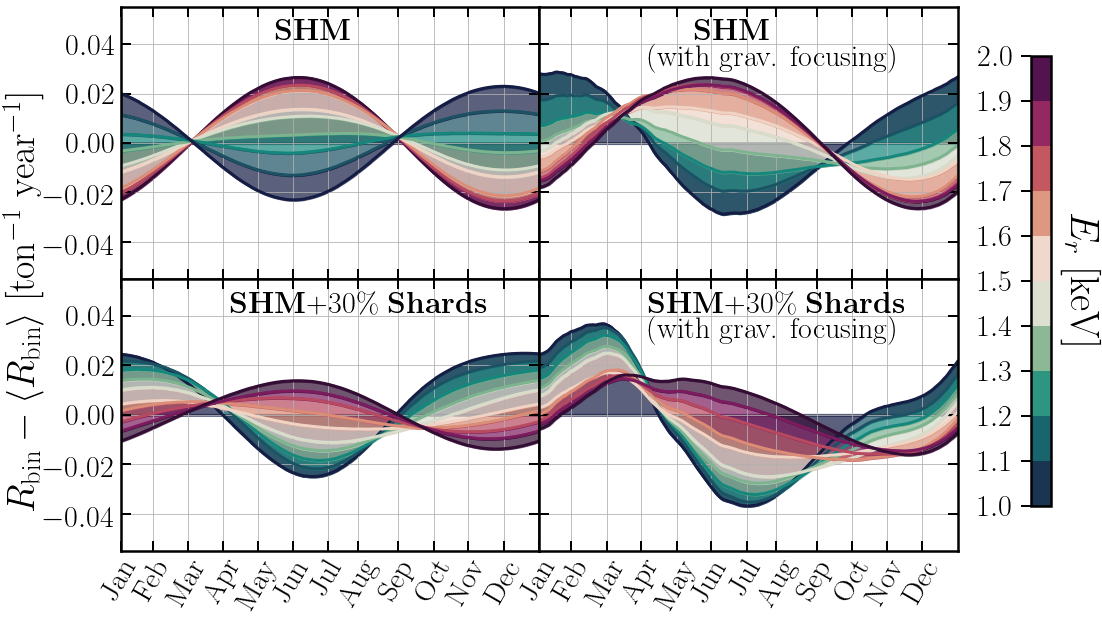

In [83]:
import matplotlib.gridspec as gridspec
pltname = 'Shards_annualmod_gravfocus_Energies'
import pandas


nbins = 10
bin_edges = linspace(1.0,2.0,nbins+1)

def bin_dR(fdR):
    Rbin = zeros(shape=(ndays,nbins))
    for i in range(0,ndays):
        for j in range(0,nbins):
            E1 = bin_edges[j]
            E2 = bin_edges[j+1]
            Ec = E_ee[(E_ee>E1)&(E_ee<E2)]
            dRc = fdR[i,(E_ee>E1)&(E_ee<E2)]
            Rbin[i,j] = trapz(dRc,Ec)
    return Rbin

Rbin0 = bin_dR(dR0)
Rbin0_gf = bin_dR(dR0_gf)
Rbin = bin_dR((1-0.3)*dR0+0.3*dR)
Rbin_gf = bin_dR((1-0.3)*dR0_gf+0.3*dR_gf)

for i in range(0,nbins):
    Rbin0_gf[:,i] = pandas.rolling_mean(Rbin0_gf[:,i],9,min_periods=1)
    Rbin_gf[:,i] = pandas.rolling_mean(Rbin_gf[:,i],9,min_periods=1)
#Rbin0_gf[isnan(Rbin0_gf)] = Rbin0_gf[0,5]
#Rbin_gf[isnan(Rbin_gf)] = Rbin_gf[0,5]
   
# Set up subplots
fig, axarr = plt.subplots(2, 2,figsize=(15,10))
gs = gridspec.GridSpec(2, 2)
gs.update(hspace=0.0,wspace=0.0)
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1])
ax3 = plt.subplot(gs[1,0])
ax4 = plt.subplot(gs[1,1])

ymax = 0.055
labelx = 135
labely = 0.75*ymax
ticklocs = cumsum([31,28,31,30,31,30,31,31,30,31,30,31])-31
ticklocs[7] -= 5
ticklabs = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
ytx = [-0.04,-0.02,0.0,0.02,0.04]
plt.sca(ax1)
import cmocean
colbins = (cmocean.cm.curl(linspace(0,1,nbins)))
cmap = cmocean.cm.curl
y2 = 0.0
for j in range(0,nbins):
    i = nbins-1-j
    yc = Rbin0[:,i]
    Rmid = (max(yc)+min(yc))/2.0
    plt.fill_between(days,yc-Rmid,y2=y2,linewidth=3,color=colbins[i,:],alpha=0.7)
    y2 = yc-Rmid
    plt.plot(days,yc-Rmid,'-',linewidth=3,color=colbins[i,:])
plt.xticks(ticklocs)
plt.text(labelx,labely,r'{\bf SHM}',fontsize=30)
plt.yticks(ytx)

    
plt.sca(ax2)
y2 = 0.0
for i in range(0,nbins):
    yc = Rbin0_gf[:,i]
    Rmid = (max(yc)+min(yc))/2.0
    plt.fill_between(days,yc-Rmid,y2=y2,linewidth=3,color=colbins[i,:],alpha=0.7)
    y2 = yc-Rmid
    plt.plot(days,yc-Rmid,'-',linewidth=3,color=colbins[i,:])
plt.xticks(ticklocs)
plt.text(labelx,labely,r'{\bf SHM}',fontsize=30)
plt.text(labelx-40,labely-0.01,r'(with grav. focusing)',fontsize=30)
plt.yticks(ytx)

plt.sca(ax3)
y2 = 0.0
for i in range(0,nbins):
    yc = Rbin[:,i]
    Rmid = (max(yc)+min(yc))/2.0
    plt.fill_between(days,yc-Rmid,y2=y2,linewidth=3,color=colbins[i,:],alpha=0.7)
    y2 = yc-Rmid
    plt.plot(days,yc-Rmid,'-',linewidth=3,color=colbins[i,:])
plt.xticks(ticklocs,ticklabs,rotation=60)
plt.text(labelx-40,labely,r'{\bf SHM}+30\% {\bf Shards}',fontsize=30)
plt.yticks(ytx)


plt.sca(ax4)
y2 = 0.0
for i in range(0,nbins):
    yc = Rbin_gf[:,i]
    Rmid = (max(yc)+min(yc))/2.0
    plt.fill_between(days,yc-Rmid,y2=y2,linewidth=3,color=colbins[i,:],alpha=0.7)
    y2 = yc-Rmid
    plt.plot(days,yc-Rmid,'-',linewidth=3,color=colbins[i,:])   
plt.xticks(ticklocs,ticklabs,rotation=60)
plt.text(labelx-40,labely,r'{\bf SHM}+30\% {\bf Shards}',fontsize=30)
plt.text(labelx-40,labely-0.01,r'(with grav. focusing)',fontsize=30)
plt.yticks(ytx)

    
ax1.set_xticklabels([])
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax4.set_yticklabels([])


ax1.set_xlim([0,days[-1]])
ax2.set_xlim([0,days[-1]])
ax3.set_xlim([0,days[-1]])
ax4.set_xlim([0,days[-1]])
ax1.set_ylim([-ymax,ymax])
ax2.set_ylim([-ymax,ymax])
ax3.set_ylim([-ymax,ymax])
ax4.set_ylim([-ymax,ymax])

# Custom colorbar
cbaxes = inset_axes(ax2, width="10%", height="90%", bbox_to_anchor=[870, 90, 200, 500]) 
norm = mpl.colors.Normalize(vmin=bin_edges[0],vmax=bin_edges[-1])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm,cax=cbaxes,ticks=around(bin_edges,2),boundaries=around(bin_edges,2),orientation='vertical')
f = plt.gcf().get_children()
cbar = f[5]
cbar.tick_params(labelsize=20) 
cbar.tick_params(which='major',direction='out',width=2,length=10,left=True,right=False,pad=7,labelsize=30)
cbar.tick_params(which='minor',direction='out',width=2,length=7,left=True,right=False)
cbar.yaxis.set_ticks_position('left')
cbar.set_ylabel(r'$E_r$ [keV]',rotation=-90,labelpad=45)
cbar.yaxis.label.set_size(40)
#cbar.yaxis.set_label_position("right")
ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
ax1.tick_params(which='major',direction='in',width=2,length=10,right=True,top=True,pad=5,labelsize=30)
ax1.tick_params(which='minor',direction='in',width=1,length=7,right=True,top=True)
ax2.tick_params(which='major',direction='in',width=2,length=10,right=True,top=True,pad=5,labelsize=30)
ax2.tick_params(which='minor',direction='in',width=1,length=7,right=True,top=True)
ax3.tick_params(which='major',direction='in',width=2,length=10,right=True,top=True,pad=5,labelsize=30)
ax3.tick_params(which='minor',direction='in',width=1,length=7,right=True,top=True)
ax4.tick_params(which='major',direction='in',width=2,length=10,right=True,top=True,pad=5,labelsize=30)
ax4.tick_params(which='minor',direction='in',width=1,length=7,right=True,top=True)

#ax1.set_ylabel(r'\quad\quad\quad$R_{\rm bin}-\langle R_{\rm bin}\rangle$ [ton$^{-1}$ year$^{-1}$]',fontsize=30)
#ax3.set_ylabel(r'\quad\quad\quad$R_{\rm bin}-\langle R_{\rm bin}\rangle$ [ton$^{-1}$ year$^{-1}$]',fontsize=30)
plt.gcf().text(0.02,0.72,r'\quad\quad\quad$R_{\rm bin}-\langle R_{\rm bin}\rangle$ [ton$^{-1}$ year$^{-1}$]',rotation=90,fontsize=38)

plt.show()
fig.savefig('../plots/'+pltname+'.pdf',bbox_inches='tight')
fig.savefig('../plots/plots_png/'+pltname+'.png',bbox_inches='tight')

/Users/ciaranohare/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  """


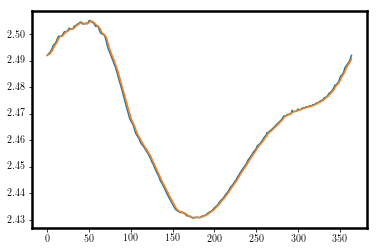

In [81]:
import pandas

plt.plot(Rbin_gf[:,0])

smooth_data = pandas.rolling_mean(Rbin_gf[:,0],4,min_periods=1)
plt.plot(smooth_data)

plt.show()

In [82]:
smooth_data

array([ 2.49203435,  2.49219609,  2.49235088,  2.49251779,  2.4928638 ,
        2.49330795,  2.49379583,  2.49442098,  2.49506843,  2.49562432,
        2.49612582,  2.49656303,  2.49707962,  2.49773024,  2.49840759,
        2.49887697,  2.49916838,  2.49923573,  2.499308  ,  2.49953643,
        2.49990417,  2.50033411,  2.50067423,  2.50089927,  2.50103813,
        2.50117459,  2.50146856,  2.50179048,  2.50199324,  2.50209936,
        2.5020576 ,  2.50202105,  2.50222445,  2.50252105,  2.50285057,
        2.50318395,  2.50340898,  2.5036221 ,  2.50381496,  2.5040688 ,
        2.50426599,  2.50440809,  2.50438464,  2.50424314,  2.5040667 ,
        2.50390392,  2.5039704 ,  2.50402099,  2.50404839,  2.50416761,
        2.50436582,  2.50465216,  2.50489298,  2.50497603,  2.50484199,
        2.50463441,  2.50441161,  2.50411789,  2.50373987,  2.50339787,
        2.5031963 ,  2.50303515,  2.50280372,  2.50232292,  2.50162179,
        2.50096898,  2.50046458,  2.50016444,  2.49999828,  2.49